In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import modules as mod
import networkx as nx
from scipy.optimize import curve_fit
from scipy.stats import norm

### Global parameters

In [136]:
# Number of market participants 
N = 1600 

# Number of fundamentalists and chartists
N_FUND = 600
N_CHART = 1000

# Initial price of the asset traded
P_0 = 100

# Global fundamental price 
P_F = 120

# Variation around the global fundamental price 
THETA = 25

# Maximum extension for chartists' timesteps window 
T_MAX = 10

# Sensitivity of forecasts for fundamentalists
PHI = 2.0

# Sensitivity of forecasts for chartists 
KAPPA = 2.0

# level of information dissipation among the agents
ALPHA = 0.95

# Weight of the market imbalance
DELTA = 0.05

# Intervals of variation for the stochastic noise term 
SIGMA = 30

# Sensitivity threshold for choosing the status
TAO = 20

# Asset quantity for each trader
Q = 500

# Information Threshhold
Ith = 1

# Initializing traders' wealth (W), money (M), and asset quantity(Q)
M = 35000  
Q = 500 
W = [M + Q * P_0 for _ in range(N)] 

In [137]:
import pickle
# Open the file for reading
with open('my_data.pkl', 'rb') as file:
    data = pickle.load(file)

# Extracting the dictionary and list
loaded_dict = data['ob.agents_dict']
loaded_list = data['ob.info_counts']

In [138]:
# Function to calculate expected price for one fundamentalist
def ep_fundamentalist(p_t, P_F):
    """
    Calculate the expected price for a fundamentalist trader

    Parameters:
    p_t (float): The current market price of the asset
    p_f (float): The perceived fundamental price of the asset for the trader

    Returns:
    float: The expected price for the asset for a fundamentalist trader
    """
    noise = np.random.uniform(-SIGMA, SIGMA)
    # Was not too sure about using an uniform or normal distribution here
    p_f = np.random.uniform(P_F - THETA, P_F + THETA)
    return p_t + PHI * (p_f - p_t) + noise

# Function to calculate expected price for one chartist
def ep_chartist(p_t, past_prices):
    """
    Calculate the expected price for a chartist trader

    Parameters:
    p_t (float): The current market price of the asset
    past_prices (list of float): A list of past market prices of the asset

    Returns:
    float: The expected price for the asset as calculated by a chartist trader
    """
    assert len(past_prices) == T_MAX, "past_prices must be a list of 15 values"
    chartist_T = np.random.randint(2, T_MAX)
    p_T = np.mean(past_prices[-chartist_T:]) 
    noise = np.random.uniform(-SIGMA, SIGMA)
    return p_t + KAPPA/(chartist_T) * (p_t - p_T) + noise

# Function that determines the choice one random trader makes
def rand_trader():
    choice = np.random.randint(0, 3)
    return choice
    

In [139]:
# Function to calculate the order type for a non-random trader
def determine_order_type(expected_price, p_t, TAO, money, asset_quantity):
    """
    Determine the order type of a trader based on the expected price, current price,
    sensitivity threshold, available money, and asset quantity

    Parameters:
    expected_price (float): The expected price of the asset
    p_t (float): The current market price of the asset
    TAO (int): The threshold to decide whether to hold
    money (float): The amount of money the trader has
    asset_quantity (int): The quantity of the asset the trader holds

    Returns:
    str: The order type ('buy', 'sell', or 'hold')
    """

    if abs(expected_price - p_t) <= TAO:
        return 'hold'
    elif expected_price > p_t and money > 0:
        return 'buy'
    elif expected_price < p_t and asset_quantity > 0:
        return 'sell'
    else:
        return 'hold'

def set_order_price(order_type, expected_price, current_price, money):
    """
    Set the order price for a trader based on their order type, expected price,
    current price, and the amount of money they have

    Parameters:
    order_type (str): The type of order ('buy', 'sell', or 'hold')
    expected_price (float): The expected price of the asset
    current_price (float): The current market price of the asset
    money (float): The amount of money the trader has
    
    Returns:
    float: The price set for the order
    """
    if order_type == 'buy':
        return np.random.uniform(0, min(money, expected_price ))
    elif order_type == 'sell':
        return np.random.uniform(expected_price, current_price)
    else:
        return 0

In [140]:
# Example usage
current_market_price = P_0
trader_money = M
trader_asset_quantity = Q

ep = ep_fundamentalist(current_market_price, P_F) 
order_type = determine_order_type(ep, P_0, TAO, trader_money, trader_asset_quantity)
order_price = set_order_price(order_type, ep, current_market_price, trader_money)

print(ep)
print(order_type)
print(order_price)

166.57619744803605
buy
42.56415373560732


In [141]:
class OrderBook:
    def __init__(self, delta, alpha, network):
        """
        Initialize the OrderBook with the given delta value.

        Parameters:
        - delta (float): Parameter for price adjustment.
        """
        self.bids = []  # List to store bid orders
        self.asks = []  # List to store ask orders
        self.delta = delta  # Parameter for price adjustment
        self.N_a = 0 # Number of asks
        self.N_b = 0 # Number of bids
        self.N_T = 0 # Number of trades
        self.agents_dict = {} # Dictionary containing each agents and information
        self.network = network
        self.state_counts = {'buy': [], 'sell': [], 'hold': []}
        self.info_counts = []
        self.alpha = alpha
        self.Ith = Ith
        self.trade_counts = [] # Keep track of amount of trades per simulation
        
    def place_bid(self, trader_id, price):
        """
        Place a bid order in the order book.

        Parameters:
        - trader_id (int): ID of the trader placing the bid.
        - price (float): Bid price.
        """
        self.bids.append({'trader_id': trader_id, 'price': price})
        self.N_b += 1  # Increment the number of bidders
        
    def place_ask(self, trader_id, price):
        """
        Place an ask order in the order book.

        Parameters:
        - trader_id (int): ID of the trader placing the ask.
        - price (float): Ask price.
        """
        self.asks.append({'trader_id': trader_id, 'price': price})
        self.N_a += 1  # Increment the number of askers
        
    def propagate_info(self, agent_index):
        """
        Propagate the information of an agent to its neighbors in the network.

        If the agent's information is greater than or equal to the threshold `Ith`, 
        the information is stored and the agent's information is set to 0. Then, 
        the stored information is distributed to each neighbor in proportion to `ALPHA / number of neighbors`. 
        If the distributed information is greater than or equal to the threshold `Ith`, 
        the agent's decision is propagated to the neighbor, and the `propagate_info` function is recursively called.

        Parameters:
        agent_index (int): The index of the agent in the agents list.
        """
        agent = self.agents_dict[agent_index]
        neighbors = list(self.network.neighbors(agent_index))
        if agent[6] >= self.Ith: # 6 is index for info 
            self.info_counts[-1] += 1
            store_info = agent[6]
            self.agents_dict[agent_index][6] = 0 # TAKE A GOOD LOOK WHETHER THIS IS CORRECT ON THE SIM
            for neighbor in neighbors:
                self.agents_dict[neighbor][5] = agent[5]
                self.agents_dict[neighbor][6] += (self.alpha / len(neighbors)) * store_info
                self.agents_dict[neighbor][6] = min(self.agents_dict[neighbor][6], np.finfo(float).max)
                if self.agents_dict[neighbor][6] >= self.Ith:
                    self.propagate_info(neighbor)  # Recursive call
        
    def network_cycle(self):
        """
        Update the network for one simulation cycle and collect information for futures plots.
        """
        self.info_counts.append(0) # Agent information threshhold cross counter
        copy_agents = self.agents_dict.copy()
        # Add global information
        for agent_id in self.agents_dict:
            self.agents_dict[agent_id][6] += np.random.uniform(0, 
                                            (self.Ith - max([copy_agents[agent_id][6] for agent_id in copy_agents])))
        # Contagion mechanism
        for i, agent in enumerate(self.agents_dict):
            self.propagate_info(i)

        current_state_counts = {'buy': 0, 'sell': 0, 'hold': 0}
        for agent_id in self.agents_dict:
            current_state_counts[self.agents_dict[agent_id][5]] += 1
        for state in self.state_counts:
            self.state_counts[state].append(current_state_counts[state])
                
    def match_orders(self):
        """
        Match bid and ask orders in the order book.

        Returns:
        - list: List of dictionaries representing matched transactions.
        """
        self.bids.sort(key=lambda x: x['price'], reverse=True)
        self.asks.sort(key=lambda x: x['price'])
        N_T = 0 
        while self.bids and self.asks:
            best_bid = self.bids[0]
            best_ask = self.asks[0]

            if best_bid['price'] >= best_ask['price']:
                # Remove matched orders
                p_L = self.asks[0]['price']
                self.agents_dict[self.asks[0]['trader_id']][3] -= 1 ## assets
                self.agents_dict[self.bids[0]['trader_id']][3] += 1 
                self.agents_dict[self.asks[0]['trader_id']][2] += p_L  
                self.agents_dict[self.bids[0]['trader_id']][2] -= p_L
                self.bids.pop(0)
                self.asks.pop(0)
                self.N_b -= 1
                self.N_a -= 1
                N_T += 1
            
            else:
                break  # No more possible transactions
        self.trade_counts.append(N_T)
        return N_T, p_L

    def set_aggregate_price(self, prev_price):
        """
        Set the aggregate asset price at time t + 1 based on different cases.

        Parameters:
        - prev_price (float): Previous global asset price at time t.
        - N_a (int): Number of askers in the order book.
        - N_b (int): Number of bidders in the order book.

        Returns:
        - float: New global asset price at time t + 1.
        """
        self.bids.sort(key=lambda x: x['price'], reverse=True)
        self.asks.sort(key=lambda x: x['price'])
        
#         print('CURRENT PRICE', prev_price)
#         print('BEST BID', self.bids[0])
#         print('BEST BID AGENT', self.agents_dict[self.bids[0]['trader_id']])
#         print('BEST ASK', self.asks[0])
#         print('BEST ASK AGENT', self.agents_dict[self.asks[0]['trader_id']])
        
        if self.N_a == 0 and self.N_b > 0:
            new_price = prev_price + self.delta * self.N_b
            print('1')
        elif self.N_a > 0 and self.N_b == 0:
            new_price = prev_price - self.delta * self.N_a
            print('2')
        elif 0 < self.N_a < self.N_b and self.bids[0]['price'] < self.asks[0]['price']:
            new_price = prev_price + self.delta * self.N_b
            print('3')
        elif 0 < self.N_a < self.N_b and self.bids[0]['price'] > self.asks[0]['price']:
            N_T,p_L = self.match_orders()
            new_price = p_L + self.delta * (self.N_b - N_T)
            print('4')
        elif 0 < self.N_b < self.N_a and self.bids[0]['price'] < self.asks[0]['price']:
            new_price = prev_price - self.delta * self.N_a
            print('5')
        elif 0 < self.N_b < self.N_a and self.bids[0]['price'] > self.asks[0]['price']:
            N_T, p_L = self.match_orders()
            new_price = p_L - self.delta * (self.N_a - N_T)
            print('6')
        else:
            new_price = prev_price
        self.N_a = 0
        self.N_b = 0
        self.bids = []
        self.asks = []
        return new_price


### Simulation

In [142]:
# Initialize agent attributes at T = 0

# structure of agent data
# agents = np.zeros(N, dtype=[('type', 'U10'),# 0
#                             ('wealth', 'f8'),# 1
#                             ('money', 'f8'), # 2
#                             ('assets', 'f8'), # 3
#                             ('expected_price', 'f8'), # 4
#                             ('decision', 'U10'), # 5
#                             ('info', 'f8')]) # 6

past_price = [P_0 for i in range(T_MAX)]
network = nx.watts_strogatz_graph(n=N, k=4, p=0.4) 
ob = OrderBook(DELTA, ALPHA, network)
current_market_price = P_0
simulations = 1000
asset_prices = []
for i in range(N_FUND):
    ep = ep_fundamentalist(P_0, P_F)
    #print(ep) 
    ob.agents_dict[i] = ['fund',
                 W[i],
                 M,
                 Q,
                 ep,
                 determine_order_type(ep, P_0, TAO, M, Q),
                 np.random.uniform(0, Ith)
                     ]

# # Start from where N_FUND stops for integers
for i in range(N_FUND, N_FUND+N_CHART):
    ep = ep_chartist(P_0, past_price)
    ob.agents_dict[i] = ['chart',
                 W[i],
                 M,
                 Q,
                 ep,
                 determine_order_type(ep, P_0, TAO, trader_money, trader_asset_quantity),
                 np.random.uniform(0, Ith)
                     ]

In [56]:
# Run network until T_{soc}

# for cycle in range(10000):
#     ob.network_cycle()

# ob.agents_dict = loaded_dict
# ob.info_counts = loaded_list

In [57]:
# import pickle
# # Open the file for reading
# with open('my_data.pkl', 'rb') as file:
#     data = pickle.load(file)

# # Extracting the dictionary and list
# ob.agents_dict = data['ob.agents_dict']
# ob.info_counts = data['ob.info_counts']

# # network = nx.watts_strogatz_graph(n=N, k=4, p=0.4) 
# # ob = OrderBook(DELTA, ALPHA, network)
# # current_market_price = P_0
# # simulations = 500

In [143]:
print(ob.agents_dict)

{0: ['fund', 85000, 35000, 500, 199.94375608814823, 'buy', 0.0357866078936081], 1: ['fund', 85000, 35000, 500, 176.6036855923346, 'buy', 0.5578519540314523], 2: ['fund', 85000, 35000, 500, 69.7840255467345, 'sell', 0.4075125844227597], 3: ['fund', 85000, 35000, 500, 189.73875875616804, 'buy', 0.2037085464845798], 4: ['fund', 85000, 35000, 500, 158.21924069136543, 'buy', 0.6858848309097592], 5: ['fund', 85000, 35000, 500, 127.6229819736188, 'buy', 0.28716799476373556], 6: ['fund', 85000, 35000, 500, 162.25948972997307, 'buy', 0.8732513234924338], 7: ['fund', 85000, 35000, 500, 157.8322460232967, 'buy', 0.8574606859135602], 8: ['fund', 85000, 35000, 500, 178.71507676940794, 'buy', 0.7833416243441331], 9: ['fund', 85000, 35000, 500, 183.33525325483382, 'buy', 0.608290760310368], 10: ['fund', 85000, 35000, 500, 115.50912392759994, 'hold', 0.9703363587187641], 11: ['fund', 85000, 35000, 500, 175.26296199327894, 'buy', 0.7426474345808952], 12: ['fund', 85000, 35000, 500, 107.89261982182958, 

In [144]:
agent_ids = list(ob.agents_dict.keys())

random.shuffle(agent_ids)

shuffled_agents_dict = {agent_id: ob.agents_dict[agent_id] for agent_id in agent_ids}

ob.agents_dict = shuffled_agents_dict

print(ob.agents_dict)

{921: ['chart', 85000, 35000, 500, 98.03308169096535, 'hold', 0.584190609927905], 342: ['fund', 85000, 35000, 500, 160.2900905851477, 'buy', 0.5498182428052396], 60: ['fund', 85000, 35000, 500, 97.43100242658015, 'hold', 0.8544821116104941], 190: ['fund', 85000, 35000, 500, 108.34183673740488, 'hold', 0.2812727101864968], 127: ['fund', 85000, 35000, 500, 88.05835432811958, 'hold', 0.1527480022908907], 1166: ['chart', 85000, 35000, 500, 95.61147965040774, 'hold', 0.9902960713518305], 1458: ['chart', 85000, 35000, 500, 129.22614934704418, 'buy', 0.03807869457972379], 1020: ['chart', 85000, 35000, 500, 124.92854724937568, 'buy', 0.08857864479943911], 485: ['fund', 85000, 35000, 500, 79.74026259341889, 'sell', 0.8819693246011401], 228: ['fund', 85000, 35000, 500, 181.24399385568174, 'buy', 0.6025986974805324], 966: ['chart', 85000, 35000, 500, 118.04317958091742, 'hold', 0.1287198663501381], 974: ['chart', 85000, 35000, 500, 92.92359420808417, 'hold', 0.8631036910402379], 635: ['chart', 85

In [161]:
# Simulation 1 cycle
# Initialize the dictionary to store the data at specific timesteps
data_at_timesteps = {0: {}, 100: {}, 360: {}, 1000: {}, 20000: {}}

for sim in range(20001):
    ob.network_cycle()
    for agent_id in ob.agents_dict:
        decision = ob.agents_dict[agent_id][5]
        order_price = set_order_price(decision, ob.agents_dict[agent_id][4], current_market_price, ob.agents_dict[agent_id][2])
        if decision == "buy":
            ob.place_bid(agent_id, order_price)
        elif decision == "sell":
            ob.place_ask(agent_id, order_price)
            
    current_market_price = ob.set_aggregate_price(current_market_price)
    
    asset_prices.append(current_market_price)
    past_price.pop(0)
    past_price.append(current_market_price)
    
    
    # Check if the current simulation step is one of the timesteps we're interested in
    if sim in data_at_timesteps:
        # Collect the data for this timestep
        asset_quantities_at_t = [agent[3] for agent in ob.agents_dict.values()]
        monies_at_t = [agent[2] for agent in ob.agents_dict.values()]
        total_wealths_at_t = [m + current_market_price * q for m, q in zip(monies_at_t, asset_quantities_at_t)]

        data_at_timesteps[sim]['asset_quantities'] = asset_quantities_at_t
        data_at_timesteps[sim]['monies'] = monies_at_t
        data_at_timesteps[sim]['total_wealths'] = total_wealths_at_t

    
    
    for agent_id in range(N_FUND): 
        ep = ep_fundamentalist(current_market_price, P_F) 
        ob.agents_dict[agent_id][4] = ep
        ob.agents_dict[agent_id][5] = determine_order_type(ep,
                                                    current_market_price, 
                                                    TAO, ob.agents_dict[agent_id][2],
                                                    ob.agents_dict[agent_id][3])
    for agent_id in range(N_FUND, N_FUND+N_CHART):
        ep = ep_chartist(current_market_price, past_price) 
        ob.agents_dict[agent_id][4] = ep
        ob.agents_dict[agent_id][5] = determine_order_type(ep,
                                                    current_market_price, 
                                                    TAO, ob.agents_dict[agent_id][2],
                                                    ob.agents_dict[agent_id][3])

    
#     ob = OrderBook(DELTA, ALPHA, ob.agents_dict, ob.info_counts, ob.state_counts, ob.trade_counts)

4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
6
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


In [61]:
# import pickle

# # Assuming my_dict and my_list are your dictionary and list
# agents_dict = ob.agents_dict
# asset_prices = asset_prices

# # Open a file for writing
# with open('test.pkl', 'wb') as file:
#     # Dump the dictionary and list into the file
#     pickle.dump({'agents_dict': agents_dict, 'asset_prices': asset_prices}, file)

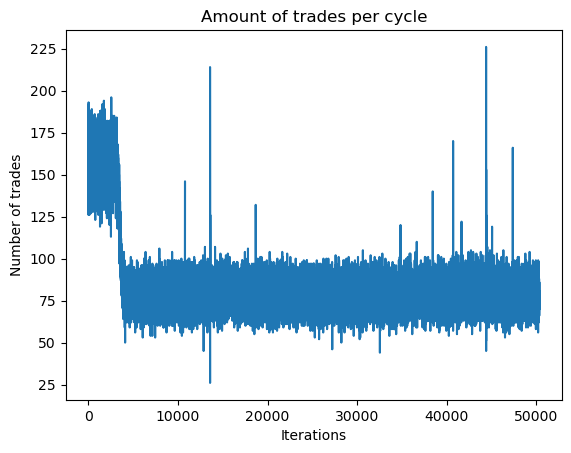

50349


In [162]:
plt.plot(list(range(len(ob.trade_counts))), ob.trade_counts, label = '#Trades')
plt.title('Amount of trades per cycle')
plt.xlabel('Iterations')
plt.ylabel('Number of trades')
plt.show()

print(len(ob.trade_counts))

In [163]:
num = 0
for agent_id in ob.agents_dict:
    print(ob.agents_dict[agent_id][2])
    num +=1
print(num)

50495.98270735481
101.55168637911925
75.71841928727416
64.62884335329213
35.52840565078641
58741.640278790896
61193.51737956822
49763.91831604373
4.885149199397617
17.555531769442652
57823.7311942201
49643.88353631073
60881.3143214376
58669.50861415831
60635.84978802126
59375.429477836624
160.8385660432932
56821.5889631423
59176.10841925499
64877.79188898743
85.75158872953043
56143.827457754596
58236.89738726456
14.382771753183832
56734.19843278835
20.878208942236313
87.96483719432254
182.60396043804639
48642.22718174304
56275.31163653176
54516.53177043179
61.116812401926836
53105.58472041974
105.61999691574525
61784.04016699827
60290.47526769849
29.247377751414234
64187.38769516187
51360.35997138426
56276.94060154654
26.619063507737337
55516.520774643184
63.973975660936304
76252.66097335903
55936.96494667186
60405.422914523486
125.2682643329566
48266.34786261656
68.42772526375678
52133.63114370756
58515.9063644409
63.57164304619303
63776.71224569221
53078.736492580785
86.2102725657755

In [164]:
money = []
zeros = 0
for agent_id in ob.agents_dict:
    money.append(ob.agents_dict[agent_id][2])
    if ob.agents_dict[agent_id][3] == 0:
        print(ob.agents_dict[agent_id][0])
        zeros += 1
print(zeros)

0


Text(0, 0.5, 'Price')

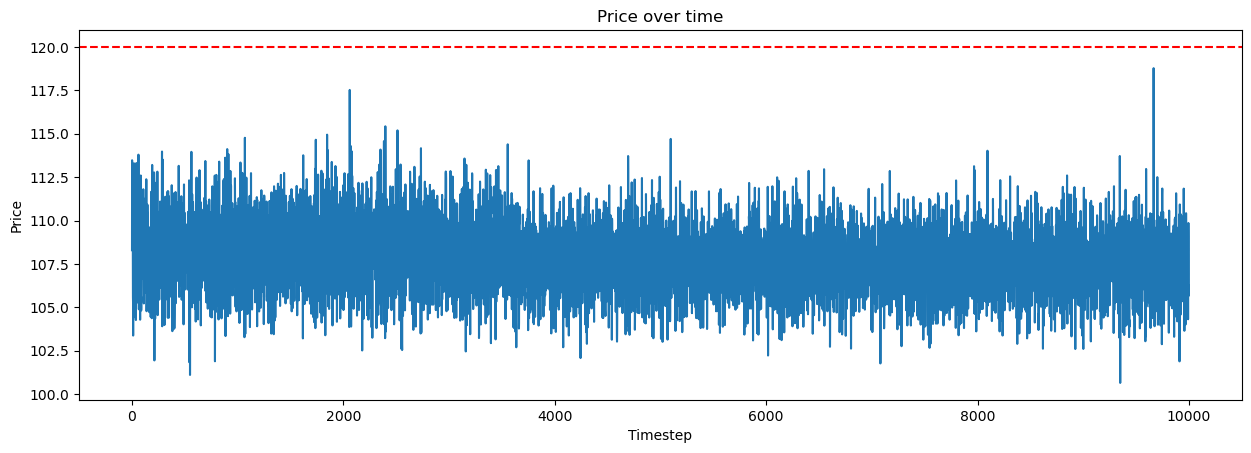

In [165]:
plt.figure().set_figwidth(15)
plt.plot(list(range(10000)), asset_prices[:10000], label ='asset price')
plt.axhline(y=120, color='r', linestyle='--', label='fundamental price 120')
plt.title("Price over time")
plt.xlabel("Timestep")
plt.ylabel("Price")

In [166]:
print(len(asset_prices))

50350


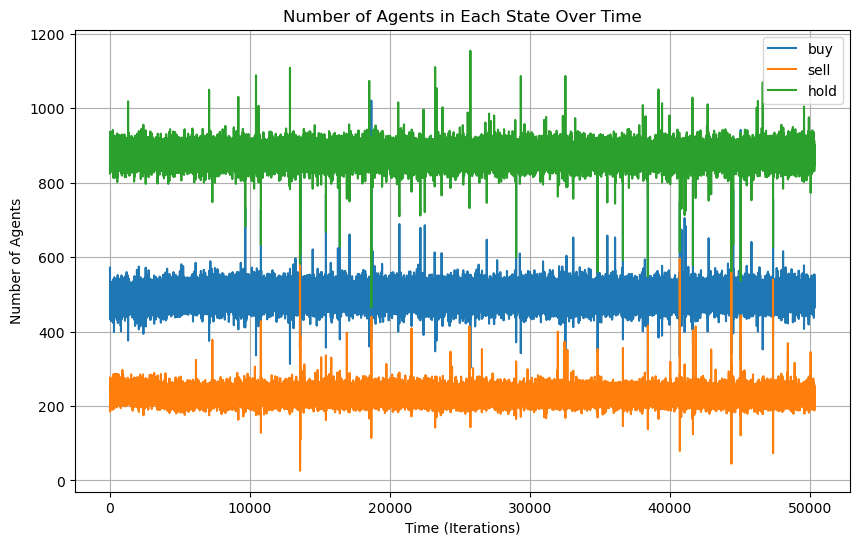

In [167]:
# After the simulation ends, create a chart to show the number of agents in each state over time
plt.figure(figsize=(10, 6))
for state, counts in ob.state_counts.items():
    plt.plot(range(len(counts)), counts, label=state)
# plt.plot(range(len(ob.info_counts)), ob.info_counts, label='info > 1')  # Plot the count of agents with info > 1
plt.xlabel('Time (Iterations)')
plt.ylabel('Number of Agents')
plt.title('Number of Agents in Each State Over Time')
plt.legend()
plt.grid(True)
plt.savefig("soc_network.png")
plt.show()

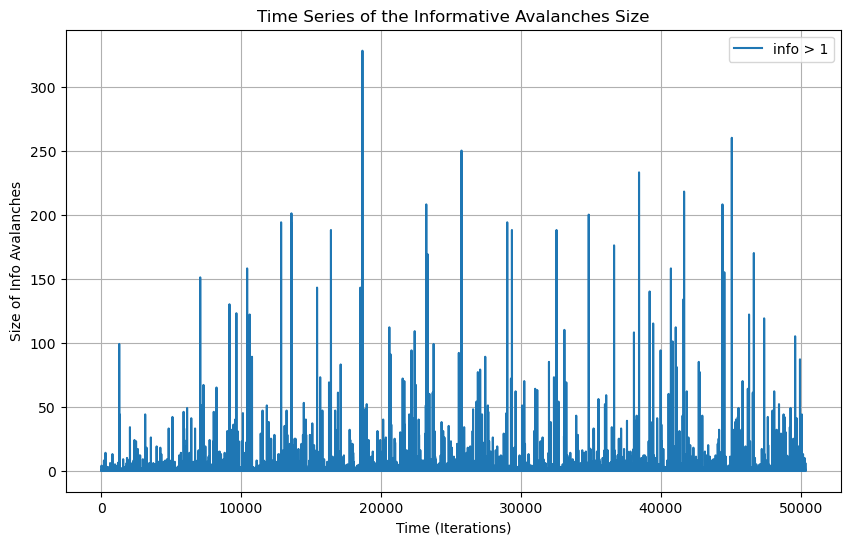

In [168]:
# After the simulation ends, create a chart to show the number of agents in each state over time
plt.figure(figsize=(10, 6))
# for state, counts in ob.state_counts.items():
#     plt.plot(range(len(counts)), counts, label=state)
plt.plot(range(len(ob.info_counts)), ob.info_counts, label='info > 1')  # Plot the count of agents with info > 1
plt.xlabel('Time (Iterations)')
plt.ylabel('Size of Info Avalanches')
plt.title('Time Series of the Informative Avalanches Size')
plt.legend()
plt.grid(True)
plt.savefig("soc_network.png")
plt.show()

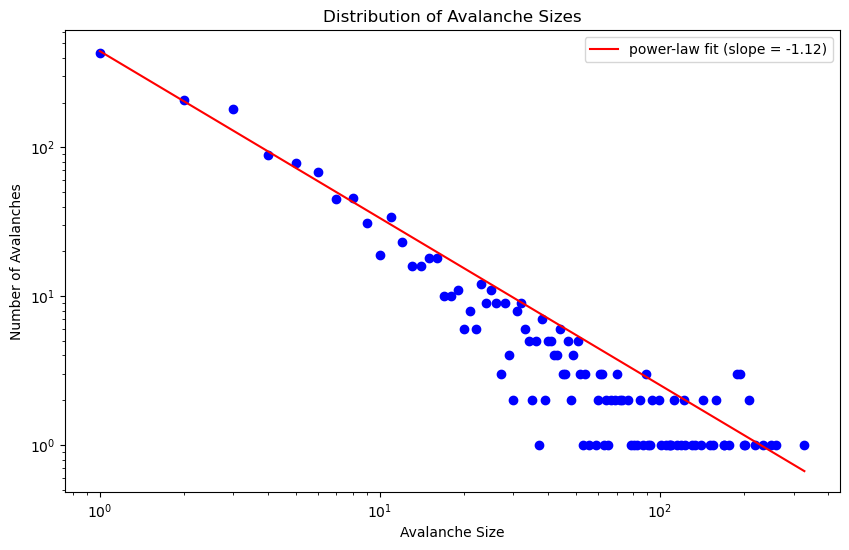

In [169]:
# Filter out the time steps where no avalanche occurred
avalanche_sizes = np.array(ob.info_counts)
avalanche_sizes = avalanche_sizes[avalanche_sizes > 0]

# Calculate the unique avalanche sizes and their counts
avalanche_sizes, counts = np.unique(avalanche_sizes, return_counts=True)

# Define the power-law function for fitting
def power_law(x, a, b):
    return a * np.power(x, b)

# Fit the power-law curve to the data
params, _ = curve_fit(power_law, avalanche_sizes, counts)

# Unpack fitting parameters for plotting
a, b = params

plt.figure(figsize=(10, 6))
plt.scatter(avalanche_sizes, counts, color='blue')  # Scatter plot of the raw data

# Generate points for the fitted line
fitted_line = power_law(avalanche_sizes, a, b)

# Plot the fitted line
plt.plot(avalanche_sizes, fitted_line, label=f'power-law fit (slope = {b:.2f})', color='red')

# Set the plot to log-log scale
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Avalanche Size')
plt.ylabel('Number of Avalanches')
plt.title('Distribution of Avalanche Sizes')

plt.legend()
plt.show()

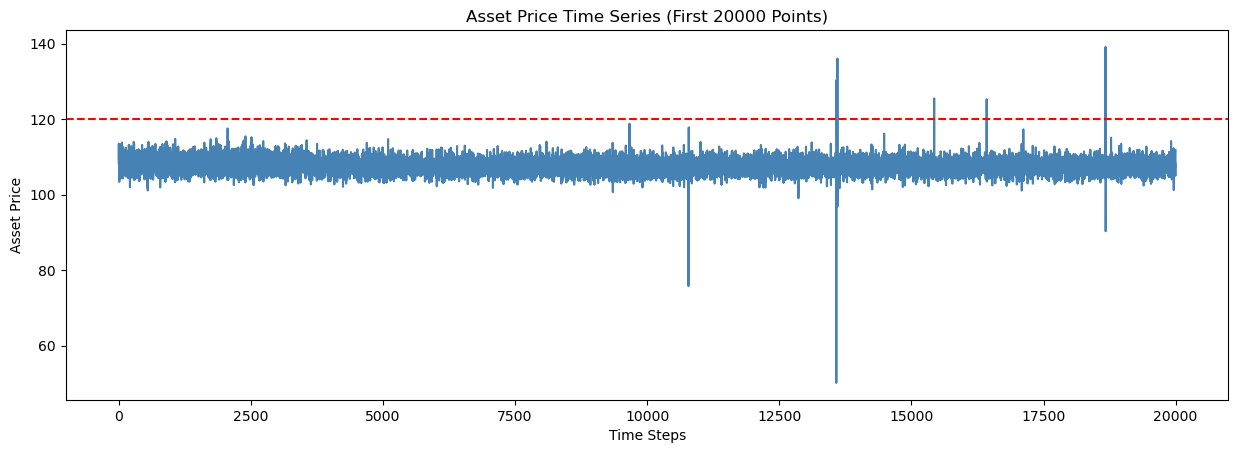

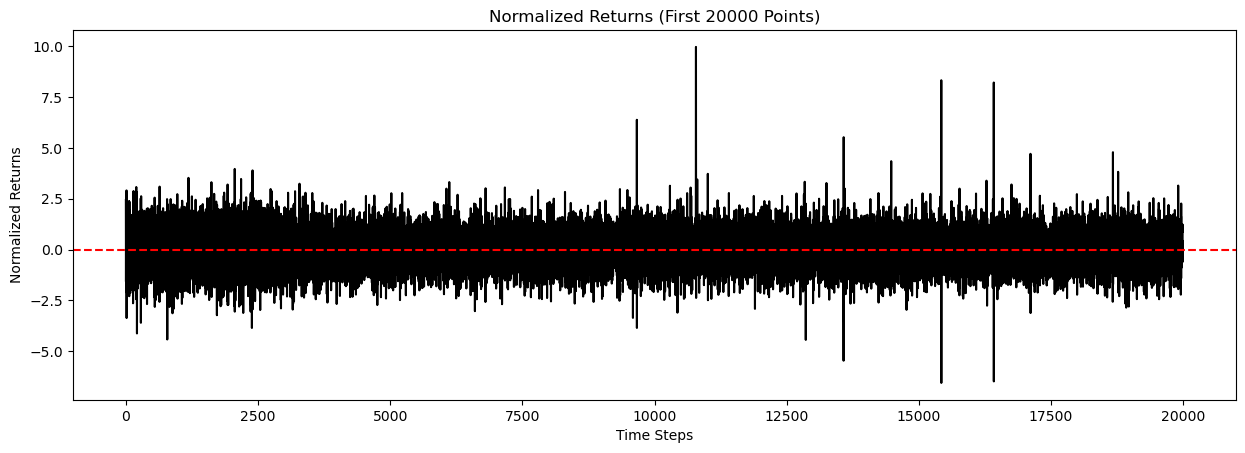

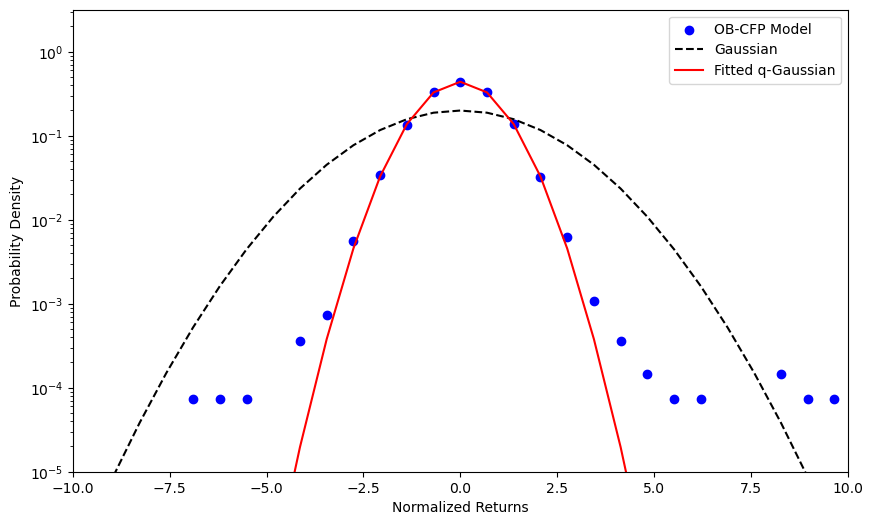

Fitted parameters for q-Gaussian: A = 0.43905294881414303, B = 0.6139238020506346, q = 1.0095554921592387
Fitted parameters for Gaussian: mu = 0, sigma = 2


In [174]:
# Use the first 20000 data points
asset_prices_subset = asset_prices[:20000]  

# Calculate returns rt
rt = np.log(asset_prices_subset[1:]) - np.log(asset_prices_subset[:-1])

# Calculate average return and standard deviation
r_avg = np.mean(rt)
r_stdev = np.std(rt)

# Calculate normalized returns r^NORM
r_norm = (rt - r_avg) / r_stdev

# Filter out extreme values, keeping only values between -10 and 10
r_norm = r_norm[(r_norm >= -10) & (r_norm <= 10)]

# Plot the asset price time series
plt.figure().set_figwidth(15)
plt.plot(asset_prices_subset, color='steelblue')
plt.axhline(y=120, color='r', linestyle='--')
plt.title('Asset Price Time Series (First 20000 Points)')
plt.xlabel('Time Steps')
plt.ylabel('Asset Price')
plt.show()

# Plot the normalized returns time series
plt.figure().set_figwidth(15)
plt.plot(r_norm, color='black')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Normalized Returns (First 20000 Points)')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Returns')
plt.show()

# Calculate the probability density function (PDF) of the normalized returns
# Create symmetrical bins
bins = np.linspace(-10, 10, 30)
counts, bin_edges = np.histogram(r_norm, bins=bins, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# mu = 0
# sigma = 4
# x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
# Gaussian = norm.pdf(bin_centers, mu, sigma)
# plt.plot(bin_centers, Gaussian, label='Gaussian', linestyle='--')



# Define the q-Gaussian function
def q_gaussian(x, A, B, q):
    # Preventing errors for q close to 1 by using np.clip to limit q
    q = np.clip(q, 1.01, 3)  # q should be greater than 1 for heavy tails
    return A * np.power(1 - (1 - q) * B * x**2, 1 / (1 - q))

# Guess initial parameters for A, B, and q. A could be 1/max(counts) for normalization,
# B could be based on the variance of the data, and q could start from a value that indicates heavy tails, e.g., 1.5.
p0 = [1 / max(counts), 1 / np.var(r_norm), 1.5]

# Fit the q-Gaussian to the data
params, _ = curve_fit(q_gaussian, bin_centers, counts, p0=p0, bounds=([0, 0, 1.01], [np.inf, np.inf, 3]))


# Define the q-Gaussian function
def q_gaussian(x, A, B, q):
    # Preventing division by zero in case q is 1
    return A * np.power(1 - (1 - q) * B * np.power(x, 2), 1 / (1 - q)) if q != 1 else A * np.exp(-B * np.power(x, 2))

# Use curve_fit to fit the q-Gaussian function to the data
params, covariance = curve_fit(q_gaussian, bin_centers, counts, p0=[1, 1, 2])


# Extract the fitted parameters for the q-Gaussian
A_fit, B_fit, q_fit = params

# Fit a Gaussian distribution using the mean and standard deviation
# mu, sigma = np.mean(r_norm), np.std(r_norm)
mu = 0
sigma = 2
Gaussian_pdf = norm.pdf(bin_centers, mu, sigma)

# Plot the PDF of the normalized returns and the fitted q-Gaussian
plt.figure(figsize=(10, 6))
plt.scatter(bin_centers, counts, label='OB-CFP Model', color='blue')

# Plot the fitted Gaussian
plt.plot(bin_centers, Gaussian_pdf, label='Gaussian', linestyle='--', color='black')
# Plot the fitted q-Gaussian curve
plt.plot(bin_centers, q_gaussian(bin_centers, *params), label='Fitted q-Gaussian', color='red')
# Set the plot to log scale for y-axis
plt.yscale('log')
# Set labels and title
plt.xlabel('Normalized Returns')
plt.ylabel('Probability Density')

# Set x-axis and y-axis limits
plt.xlim(-10, 10)
plt.ylim(10**-5, 10**0.5)

plt.legend()
plt.show()

# Print the fitted parameters for q-Gaussian
print(f"Fitted parameters for q-Gaussian: A = {A_fit}, B = {B_fit}, q = {q_fit}")

# Print the fitted parameters for Gaussian
print(f"Fitted parameters for Gaussian: mu = {mu}, sigma = {sigma}")

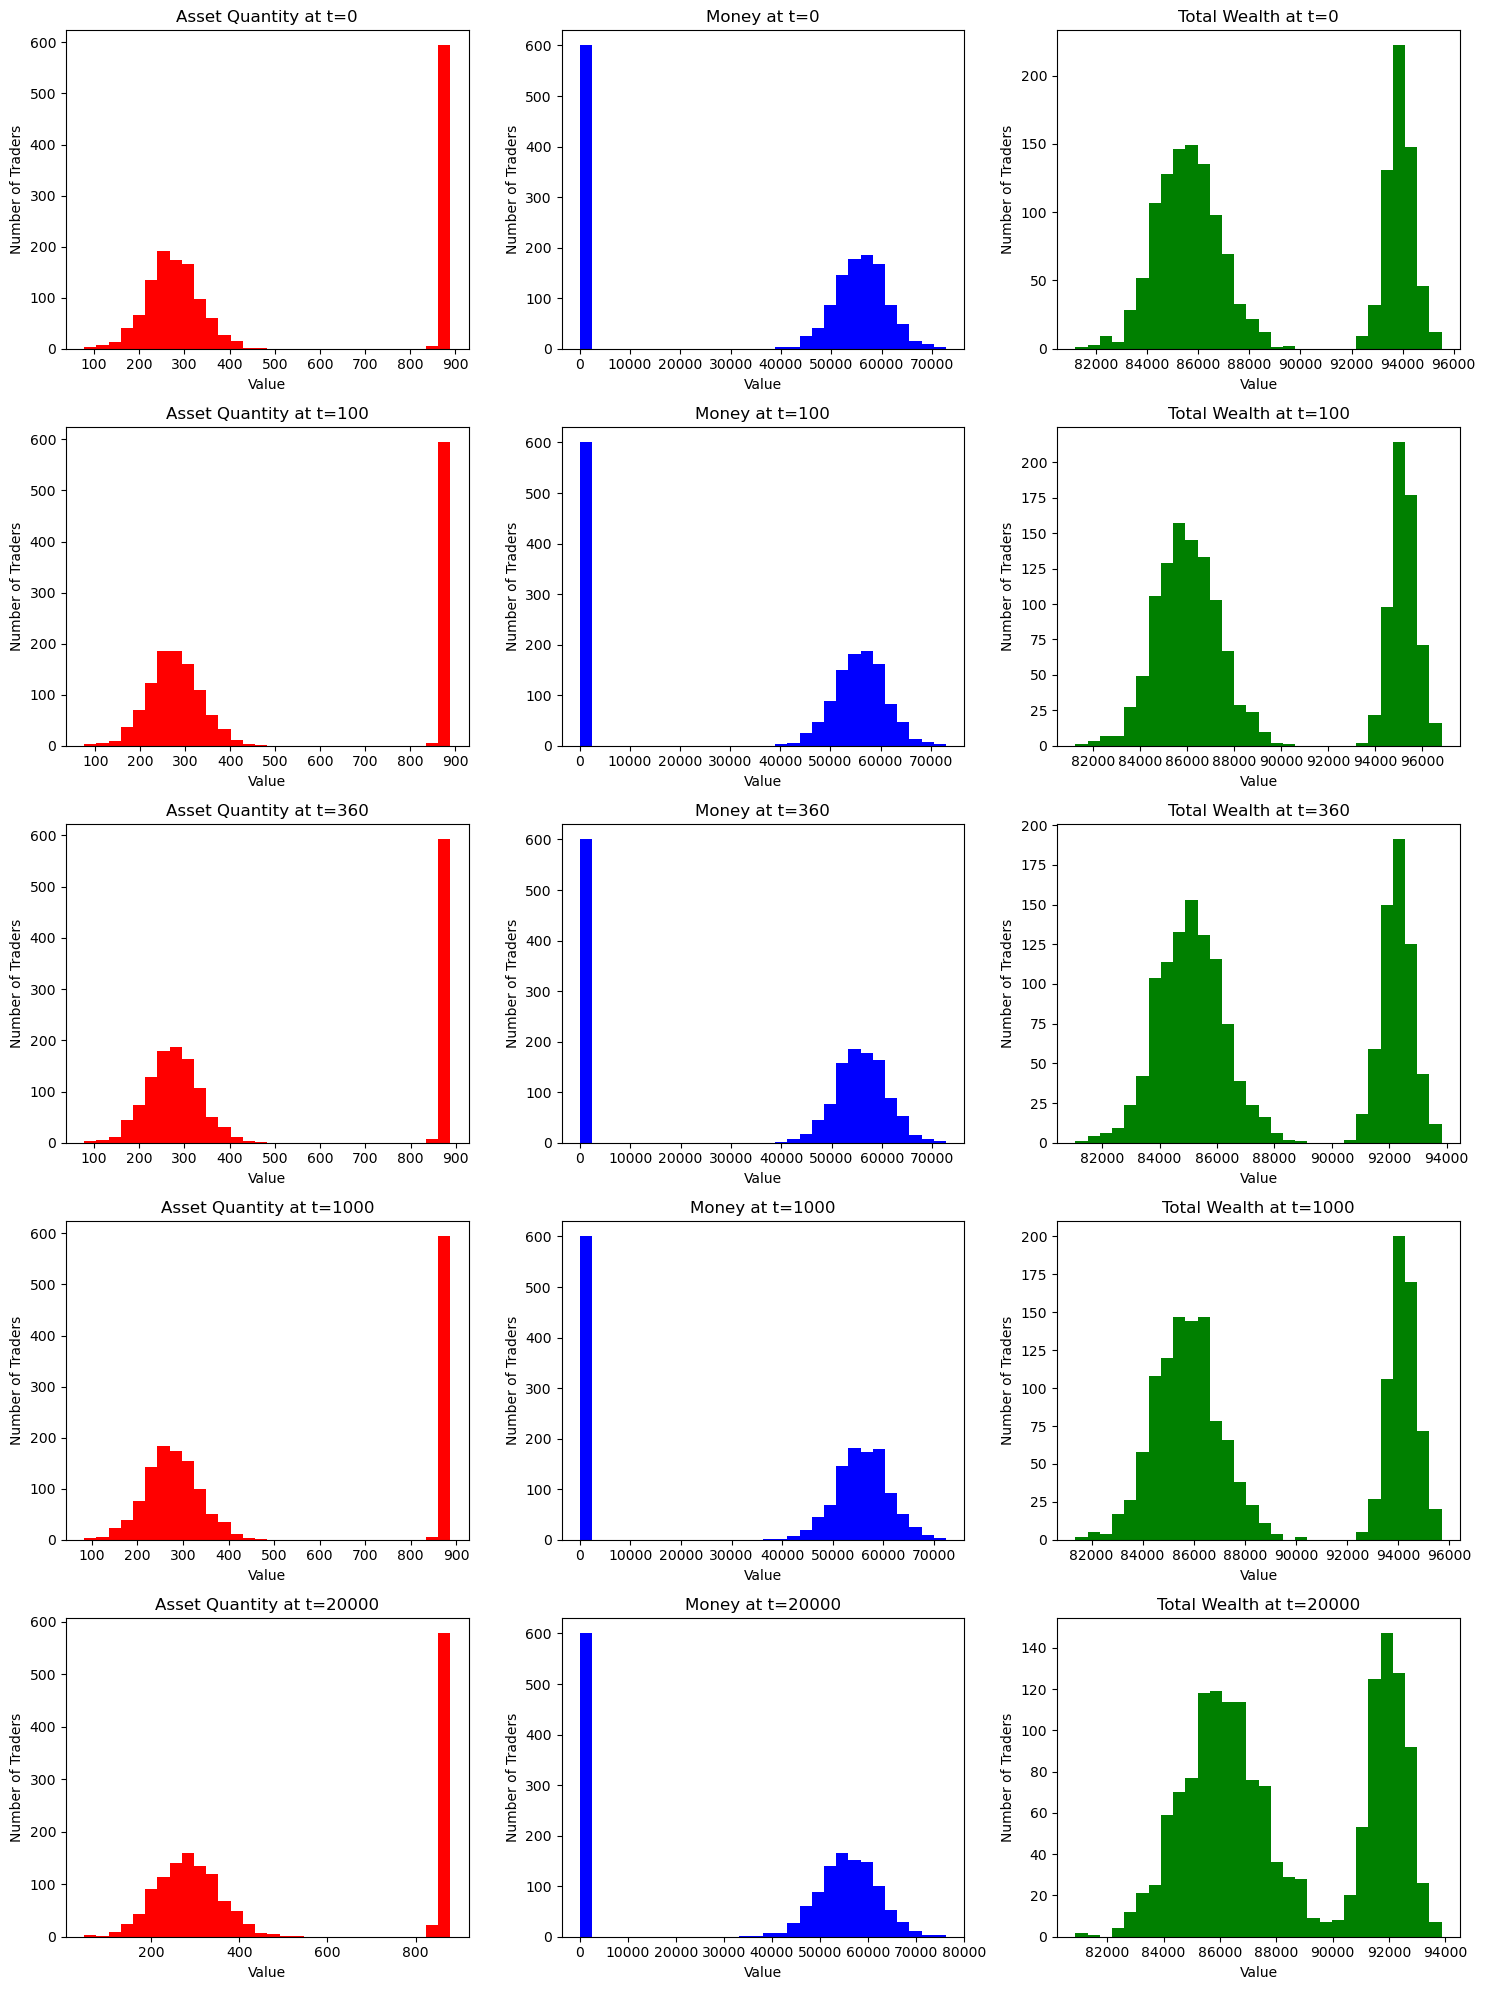

In [171]:
# Use subplots to plot the data at each timestep
fig, axs = plt.subplots(5, 3, figsize=(15, 20))  # Adjust size as needed

# Colors for different plots
colors = ['red', 'blue', 'green']

# Iterate through each timestep and each data type to plot
for i, (t, data_dict) in enumerate(data_at_timesteps.items()):
    axs[i, 0].hist(data_dict['asset_quantities'], bins=30, color=colors[0])
    axs[i, 1].hist(data_dict['monies'], bins=30, color=colors[1])
    axs[i, 2].hist(data_dict['total_wealths'], bins=30, color=colors[2])
    
    # Set titles and axis labels for each subplot
    axs[i, 0].set_title(f'Asset Quantity at t={t}')
    axs[i, 1].set_title(f'Money at t={t}')
    axs[i, 2].set_title(f'Total Wealth at t={t}')
    
    for ax in axs[i]:
        ax.set_xlabel('Value')
        ax.set_ylabel('Number of Traders')

# Adjust spacing between subplots
plt.tight_layout()
plt.show()